## Logistic Regression

This notebook is a learning resource to compliment Coursera's Machine Learning course which I recently completed. The goal is to manually tune a logistic regression without using one of the optimised modeling libraries. I'm going to use the Titanic dataset from Kaggle to make predictions about which passengers survived the shipwreck.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_raw = pd.read_csv('train.csv')
data = data_raw.copy()

**Data Preprocessing**

While data preprocessing is said to be the most important step in building a high performance model I am going to skim through this stage in order to train a model quickly as the goal of this workbook isn't model performance.


In [2]:
# Fill missing ages with the dataset average
data.Age = data.Age.fillna(data.Age.mean())

# Fill missing embarkment port with the mode
data.Embarked = data.Embarked.fillna('S')

# Convert categorical features into numeric and drop unused ones
data = pd.get_dummies(data, columns = ['Sex', 'Embarked'])
data.drop(columns=['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Name', 'PassengerId'], inplace=True)

# Drop target and convert to matrix, dimensions observations * features
features = data.drop(columns=['Survived']).to_numpy()

# Add intercept feature initalised as vector of zeros
features = np.column_stack((np.ones(len(features)), features))

# Initalise parameters as vector of zeros
parameters = np.zeros(8)

# Convert target to numpy array
target = data['Survived'].to_numpy()

# Feature names
feature_names = data.columns[1:]
feature_names = feature_names.insert(0,'Intercept')

print(f'Goal: Model Survival as a function of {" ".join(feature_names)})')

Goal: Model Survival as a function of Intercept Pclass Age Sex_female Sex_male Embarked_C Embarked_Q Embarked_S)


**Model Form**

Our model form is the sigmoid transformation of the multiple linear function Z below. Logistic regression is a classification algorithm that predicts the probablity that an observation is an instance of a class. Given some information about an individual, I need to estimate the probabilility that the individual survivied, with the class being survival and the instance being the individual.

*Z = B0x0 + B1xPclass + B2xAge + B3xSex_female + B4xSex_male + B5xEmbarked_C + B6xEmbarked_Q + B7xEmbarked_S*

Function Z can currently take on any real number depending on the parameters used. This isn't useful as a probablistic prediction given probabilities must only take on values between 0 and 1. This is where the Sigmoid function is used to map any real number to a value between 0 & 1. 

*Sigmoid(x) = 1/(1 + exp(-x))*

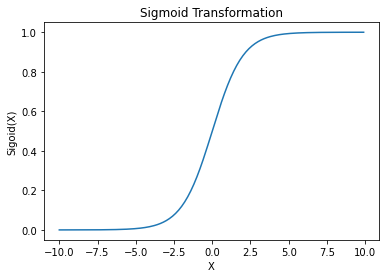

In [3]:
# Create dummy range for values
x = np.arange(-10, 10, 0.1)
sigmoid = 1/(1 + np.exp(-x))

# Plot Sigmoid function of x showing values between 0 and 1 for any value of x
fig, ax = plt.subplots()
ax.plot(x, sigmoid)
ax.set(title='Sigmoid Transformation', xlabel='X', ylabel='Sigoid(X)')
plt.show()

We will transform the output of Z with the Sigmoid function.

*Model Prediction = Sigmoid(Z)*

*Predict 1 if Sigmoid(Z) >= 0.5 else 0*

Given the output of our model will be a probability that an individual survived the shipwreck we need to quantify a threshold above which we predict the individual actually survived. 50% is an intuitive threshold over which our model predicts the positive class.

In [4]:
# Returns predictions vector given features & parameters
def predict(features, parameters):
    z = np.matmul(features,parameters)
    predictions = 1/(1 + np.exp(-z))
    return predictions

**Model Fit**

Given our model form, how do we fit the model parameters such that the predicted value is sensible for a given observation given we know the actual value of the target.

Firstly we need a metric by which we can evaluate the models predictions given the actual values of the target. Secondly we need an algorithm that tunes our model parameters to find an optimal value for the model evaluation metric.

**Cost Function**

In machine learning the general term for the metric used to evaluate a model's fit to a dataset is called a cost function. The cost function used to evaluate logistical regression is defined by Andrew Ng as below. I am going to explore how it works with hypothetical data.


![title](cost_function_log_reg.png)


In [5]:
# Generate dummy target & predictions
target_ = np.array([0, 1, 0, 1, 0]) 
predictions_ = np.array([0.009, 0.99, 0.5, 0.01, 0.99])

# Number of obsersations = m
observations_ = len(target_)

# For each observation there is two seperate cost calculations, only one of which has a non-zero value
arr = np.zeros(5)
for i in range(observations_):
    y, x = target_[i], predictions_[i]
    cost_y_1 = -y*np.log(x)
    cost_y_0 = (1-y)*np.log(1-x)
    cost = cost_y_1 - cost_y_0
    arr[i] = cost
    print(f'For observation {i} the cost is {round(cost_y_1,4)} for y=1 and {round(cost_y_0,4)} for y=0')

cost = round(arr.mean(),3)
print(f'The total cost for the model used to generate our predictions is {cost}')
print(f'This is the mean of the cost from each observation')

For observation 0 the cost is -0.0 for y=1 and -0.009 for y=0
For observation 1 the cost is 0.0101 for y=1 and -0.0 for y=0
For observation 2 the cost is -0.0 for y=1 and -0.6931 for y=0
For observation 3 the cost is 4.6052 for y=1 and -0.0 for y=0
For observation 4 the cost is -0.0 for y=1 and -4.6052 for y=0
The total cost for the model used to generate our predictions is 1.985
This is the mean of the cost from each observation


As we can see from the above output, each observation has a cost penalty associated with it that depends on the value of the target variable. We want our model to be penalised when either it predicts close to 1 when the target is  0 or it predicts close to 0 when the target is 1. Equally we do not want it to be penalised when it correctly predicts the target as either 0 or 1. 

This is all fairly intuitive but remember the output of our model is a probability, not 0 or 1. We need to consider the penality for uncertainity. Given a model threshold of 50% we will predict 1 for probabilities >= 0.5. By how much should the model be penalised for being uncertain?

The model above was uncertain about observation 2, assiging it a 50% probabilty of being 1, a coin toss. In order to understand how the penality changes with changes in the models prediction we need understand the cost as a function of the prediction.

<ipython-input-6-45248404ba0f>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


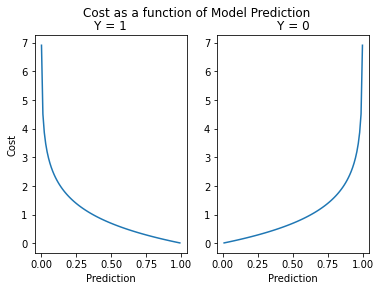

In [6]:
# Dummy predictions & costs 
x_1 = np.arange(0.001, 0.999, 0.01)
x_0 = np.arange(0.999, 0.001, -0.01)
cost_1 = -1*np.log(x_1)
cost_0 = -np.log(1-x_0)

# Plot predictions against cost
fig, ax = plt.subplots(1, 2)
fig.suptitle('Cost as a function of Model Prediction')
ax[0].plot(x_1, cost_1)
ax[0].set(xlabel='Prediction', ylabel='Cost')
ax[0].set_title('Y = 1')
ax[1].plot(x_0, cost_0)
ax[1].set(xlabel='Prediction')
ax[1].set_title('Y = 0')
fig.show()

Looking at the plots above we can see that the cost of our prediction is close to zero when our model is very certain and correct, ie predicting 0.999 when the target is equal to 1. The cost grows exponentially when the model predicts with high certainity incorrectly, ie predicting 0.999 when the target is 0. This fits with the intuition that the penality should be high when the model is very wrong. We can also see that the penality is small when the model is pretty sure and correct, ie predicting 0.8 when the target is equal to 1. This again sounds sensible. 

Below is a vectorised implementation of the cost function. Let's calculate the cost of model for the Titanic dataset with parameters initialised at zero. Given the parameter values are all zero the models prediction will be 0.5 for all observations and therefore the cost will always be equal to 0.693.

In [7]:
def cost_logistic_regression(features, parameters, target): 
    observations = len(features)
    predictions = predict(features, parameters)
    cost_positive_class = -target * np.log(predictions) 
    cost_negative_class = (1 - target) * np.log(1-predictions)
    cost = cost_positive_class - cost_negative_class
    cost = cost.sum() / observations
    return cost

cost = cost_logistic_regression(features, parameters, target)
print(f'Cost of model with zero initialised parameters: {round(cost,3)}')

Cost of model with zero initialised parameters: 0.693


**Fitting the Parameters**

We have a means to evaluate model parameters, we now need to find the optimal values for the parameters that minimise the cost function. Given the cost function evaluates how well our model fits our training data, the parameters that minimise the cost function will be most efficient parameters for our model given it's form.

Let's examine how the cost function changes for different values of the parameters with a simple example.

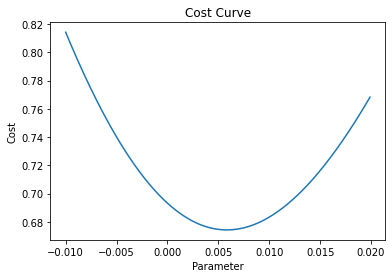

In [8]:
# Create dummy features & target
# features_ = mid-term test result, target_ = pass/fail on final exam
features_ = np.array([40, 60, 80, 15, 88, 70, 90, 35, 50, 97])
target_ = np.array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0])

# Zero valued intercept so we can use vectorised cost function
features_ = np.column_stack((np.zeros(len(features_)), features_)) 

# Compute cost function over a range of parameter values
sample_parameters = np.arange(-0.01, 0.02, 0.0001)

costs = np.zeros(len(sample_parameters))
i = 0

for b in np.nditer(sample_parameters):
    parameters_ = np.array([0, b])
    cost = cost_logistic_regression(features_, parameters_, target_)
    costs[i] = cost
    i += 1
    
# Plot cost as a function of the parameter values
fig, ax = plt.subplots()
ax.plot(sample_parameters, costs)
ax.set(title='Cost Curve', xlabel='Parameter', ylabel='Cost')
plt.show()

Refering to the plot above we can see that the value of our single parameter b that minimises the cost function is approximately 0.005. In this simplified example we can see the value for b that we require. What if our model requires more than one parameter? If optimising for 2 parameters we could use a three dimensional plot but anymore than 2 and we will loss the ability to visually solve for the optimal parameters. So we need another solution beyond visual identification. 

To this ends we need gradient descent.

Andrew Ng defines gradient descent with the below formula. Given a cost function we want to simultaneously update the values of the parameters by a learning rate * the partial derivative of the cost function with respect to the parameter being updated. I will go through this with a simplified example to explain how this works.

![title](grad_update_rule.png)

Gradient descent takes an inital value of parameters and then calculates the derivative of the cost function with respect to those parameters. The derivative of the cost function is the slope at a particular point. Given that the slope of a curve is constantly changes we can visually think of the derivative as the slope of a tangential line that just touches the curve at that point. 

Let's calculate the derivative of our cost curve for the single parameter = 0 and plot the tangential line just touching the cost curve at that point.


Using the equation above the slope of the cost curve at b = 0 is -6.55


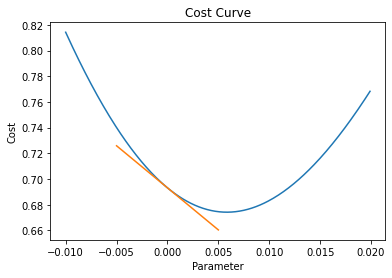

In [9]:
# Solve for the derivative of the cost curve for parameters = 0
observations_ = len(features_)
b = 0
parameters_ = np.array([0, b])
predictions_ = predict(features_, parameters_)
slope = np.matmul(features_.T, predictions_-target_)
slope /= observations_
cost = cost_logistic_regression(features_, parameters_, target_)
print(f'Using the equation above the slope of the cost curve at b = {b} is {slope[1]}')

# Compute coordinates for a tangential line given slope and initial coordinates
def compute_tangent(b, cost, slope, change_b=0.005):
    b1 = b + change_b
    b2 = b - change_b
    cost1 = cost + ((change_b) * slope) 
    cost2 = cost + ((-change_b) * slope) 
    dummy_b = np.linspace(b2, b1, 10)
    dummy_cost = np.linspace(cost2, cost1, 10)
    return dummy_b, dummy_cost

# Plot tangential line to cost curve at b = 0 
dummy_b, dummy_cost = compute_tangent(b, cost, slope[1])
fig, ax = plt.subplots()
ax.plot(sample_parameters, costs)
ax.plot(dummy_b, dummy_cost)
ax.set(title='Cost Curve', xlabel='Parameter', ylabel='Cost')
plt.show()

Gradient descent uses the derivative, or partial derivatives for multple parameters, to move down the cost curve in iterative steps. Gradient descent uses a learning rate which sets the size of the steps to make when iterating down the curve.

Let's calculate the next iterative step for our parameter value with gradient descent.


Using the equation above the slope of the cost curve at b = 0.003275 is -2.83


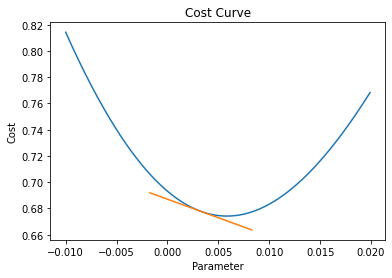

In [10]:
# Use gradient descent to update b
learning_rate = 0.0005
b -= (learning_rate * slope[1])

# Solve for the derivative of the cost curve 
observations_ = len(features_)
parameters_ = np.array([0, b])
predictions_ = predict(features_, parameters_)
slope = np.matmul(features_.T, predictions_-target_)
slope /= observations_
cost = cost_logistic_regression(features_, parameters_, target_)
print(f'Using the equation above the slope of the cost curve at b = {b} is {round(slope[1],2)}')

# Plot tangential line to cost curve at next iteration of b
dummy_b, dummy_cost = compute_tangent(b, cost, slope[1])
fig, ax = plt.subplots()
ax.plot(sample_parameters, costs)
ax.plot(dummy_b, dummy_cost)
ax.set(title='Cost Curve', xlabel='Parameter', ylabel='Cost')
plt.show()

Gradient descent uses the derivative of the cost curve and a learning rate to make iterative steps towards the parameter value that minimises the cost. Given that the derivative approaches zero as the parameter values approachs the minimum the steps taken get smaller and smaller the closer we get to the optimal solution.

The other important property to note is that it doesn't matter whether our inital value for the paramater is greater or less than the optimal value.

* If our initial value is less than the optimal value the slope is negative so we will add to the paramater value.
* If our initial value is greater than the optimal value the slope is positive so we will subtract from the paramater value. 

I'm going to put all this together and fit the parameters for the Titanic Logistic Regression using the same logic and compare to a logistic model fit with Sklearn.

Iteration: 0 Cost = 0.6931471805599453
Iteration: 500 Cost = 0.5535501161819988
Iteration: 1000 Cost = 0.5147202499720835
Iteration: 1500 Cost = 0.49551224617910583
Iteration: 2000 Cost = 0.48493413038897143
Iteration: 2500 Cost = 0.47846944901239546
Iteration: 3000 Cost = 0.4741109111911492
Iteration: 3500 Cost = 0.47091477883329746
Iteration: 4000 Cost = 0.4684127157476476
Iteration: 4500 Cost = 0.46635953665931745
Iteration: 5000 Cost = 0.46461948332196773
Iteration: 5500 Cost = 0.4631126676048104
Iteration: 6000 Cost = 0.46178889629083847
Iteration: 6500 Cost = 0.46061445753820296
Iteration: 7000 Cost = 0.45956524586232356
Iteration: 7500 Cost = 0.4586230724145633
Iteration: 8000 Cost = 0.4577736148527668
Iteration: 8500 Cost = 0.4570052308492092
Iteration: 9000 Cost = 0.45630823782903923
Iteration: 9500 Cost = 0.45567445171253756
Iteration: 10000 Cost = 0.4550968746517061
The Model Accuracy on the traing data = 0.7833894500561167


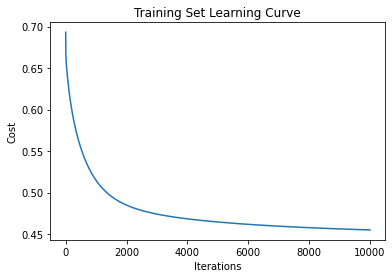

In [11]:
# Simultaniously update parameters with a learning rate and set of partial derivatives
def update_parameters(features, parameters, target, learning_rate):
    observations = len(features)
    predictions = predict(features,parameters)
    gradients = np.matmul(features.T, predictions - target)
    gradients /= observations
    gradients *= learning_rate
    parameters -= gradients  
    return parameters

# Update the parameters with gradient descent by the number of iterations
def gradient_descent(features, parameters, target, learning_rate, iterations):
    log = []
    for i in range(iterations):
        cost = cost_logistic_regression(features, parameters, target)
        parameters = update_parameters(features, parameters, target, learning_rate)
        log.append(cost)
        if i % 500 == 0:
            print('Iteration: ' + str(i) + ' Cost = ' + str(cost))
    return parameters, log  

# Fit model parameters on the training data
model_parameters, log = gradient_descent(features, parameters, target, 0.008, 10001)

# Make predictions on the training data
predictions = predict(features,model_parameters)
binary_predictions = [1 if prediction >= .50 else 0 for prediction in predictions]

# Compute model accurancy 
accurancy = sum(target == binary_predictions)/len(target)
print(f'The Model Accuracy on the traing data = {accurancy}')

# Plot learning curve
fig, ax = plt.subplots()
ax.plot(log)
ax.set(title='Training Set Learning Curve', xlabel='Iterations', ylabel='Cost')
plt.show()

In [12]:
# Fit a logistic regression using Sklearn on the same training data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='none', max_iter=5001).fit(features, target)
sk_predictions = logreg.predict(features)
alinement = sum(binary_predictions == sk_predictions)/len(sk_predictions)

# Compare models
print(f'The percentage fit between predictions and those of Sklearn is {round(alinement,2)} ')
print('Comparing specific parameters fit:')
for b, sk_b, param in zip(parameters, logreg.coef_[0], feature_names):
    b = str(round(b,1))
    sk_b = str(round(sk_b,1))
    print(f'Parameter {param}: Model {b} Sklearn {sk_b} ')

The percentage fit between predictions and those of Sklearn is 0.96 
Comparing specific parameters fit:
Parameter Intercept: Model 1.1 Sklearn 1.3 
Parameter Pclass: Model -0.8 Sklearn -1.2 
Parameter Age: Model -0.0 Sklearn -0.0 
Parameter Sex_female: Model 1.8 Sklearn 1.9 
Parameter Sex_male: Model -0.7 Sklearn -0.7 
Parameter Embarked_C: Model 0.7 Sklearn 0.6 
Parameter Embarked_Q: Model 0.2 Sklearn 0.6 
Parameter Embarked_S: Model 0.2 Sklearn 0.1 
